# **Laboratorio 11:** Redes Neuronales Convolucionales 
**Programa:** [Bootcamp en Visión Artificial para los ODS](https://github.com/EdwinTSalcedo/Bootcamp-Computer-Vision-for-the-SDGs) - **Autor:** [Edwin Salcedo](https://github.com/EdwinTSalcedo)

Las Redes Neuronales Convolucionales (CNNs) son un tipo de Red Neuronal Artificial con aprendizaje supervisado que procesa sus capas imitando al cortex visual del ojo humano para identificar distintas características en las imágenes. Esto permite que una CNN pueda identificar objetos, clasificar imágenes, o localizar elementos con mayor precisión a los modelos predecesores.

Trabajar con CNNs en TensorFlow sigue pasos similares al último laboratorio: 

- Cargar y normalizar el dataset
- Definir una Red Neuronal Convolucional 
- Definir la función de perdida y optimizador
- Entrenar la red con el subconjunto de datos de entrenamiento 
- Evaluar el modelo con el subconjunto de datos de prueba 
- (Ultimo pero no menos importante) Graficar y evaluar las metricas

Para este laboratorio, primero continuaremos trabajando con el dataset Fashion MNIST y luego nos centraremos en explorar un dataset con imágenes mas complejas.  

## **1. Redes Neuronales Convolucionales (CNNs) para el Dataset FashionMNIST**

En el último laboratorio vimos cómo entrenar un clasificador de imágenes para prendas de ropa del dataset [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) basado en una red neuronal multicapa. Aunque este modelo obtuvo métricas buenas, la red simplemente aprendió de los píxeles en bruto, y aprendio lo que formaba un suéter o una bota en este contexto. ¿Pero que pasaría su tuviese que clasificar la siguiente imagen?

<center>
<img src='https://drive.google.com/uc?id=1cdrkz-_xG-Ig7guubqnmY7_LS9ll4grm' width='30%'>
</center> 

Si bien está claro que hay una camiseta (T-Shirt) en la imagen, el clasificador fallaría por varias razones. Por ejemplo, la imagen no esta en escala de grises y tiene diferentes dimensiones a 28x28. Además, el clasificador se entrenó con los píxeles sin procesar de una camiseta orientada hacia el frente, y no hubo ninguna camiseta orientada hacia la izquierda o derecha. Finalmente, todas las prendas en el dataset tienen un fondo constante para diferenciar mejor la prenda del resto de la imagen. Pero en este caso, el fondo adicional adicional causaría un descenso desmedido de precisión si continuamos trabajando con redes neuronales normales. 

Este problema puede ser trabajado mejor con las CNNs debido a su poder de generalización. Como vimos anteriormente en el bootcamp, una convolución es un filtro que pasa sobre una imagen, la procesa y extrae características como bordes, esquinas, entre otras, las cuales permiten encontrar similitud entre imágenes. Este mismo concepto se aplica en las CNNs en múltiples capas, de tal manera que esta sea capas de extraer las características mas relevantes de un dataset y que estas características ayuden a diferenciar imágenes de categorías diferentes. 



### 1.1 Importar librerías. Descargar dataset y mostrar ejemplos. 

Los pasos en esta sección son iguales a los planteados en el inicio del anterior laboratorio. 

Las imágenes en el sub conjunto de entrenamiento tienen:
dtype: <dtype: 'uint8'>
shape: (28, 28)
max value tf.Tensor(255, shape=(), dtype=uint8)
max value tf.Tensor(0, shape=(), dtype=uint8)

Las etiquetas en el sub conjunto de entrenamiento tienen:
dtype: <dtype: 'int64'>
shape: ()
Etiqueta: tf.Tensor(2, shape=(), dtype=int64)


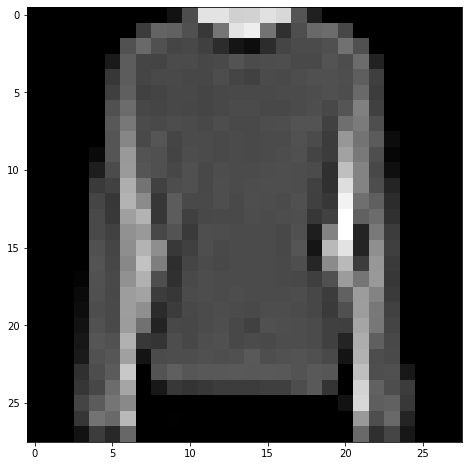

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt


training_set, dataset_info_train = tfds.load('fashion_mnist', split = 'train', as_supervised = True, with_info = True)
testing_set, dataset_info_test = tfds.load('fashion_mnist', split = 'test', as_supervised = True, with_info = True)


for image, label in training_set.take(1):
  # Remover las dimensiones con solo una unidad, la ultima en este caso -> (28, 28, 1)
  image = tf.squeeze(image)

  print('Las imágenes en el sub conjunto de entrenamiento tienen:')
  print('dtype:', image.dtype) 
  print('shape:', image.shape)
  print('max value',tf.reduce_max(image)) # Encuentra el valor máximo en un tensor
  print('max value',tf.reduce_min(image))  # Encuentra el valor mínimo en un tensor

  print('\nLas etiquetas en el sub conjunto de entrenamiento tienen:')
  print('dtype:', label.dtype) 
  print('shape:', label.shape)
  print('Etiqueta:',label)
  
  plt.imshow(image, cmap ='gray')

### 1.2 Preprocesar dataset

Los pasos en esta sección son iguales a los planteados en el inicio del anterior laboratorio. 

In [ ]:
num_training_examples = dataset_info_train.splits['train'].num_examples

def normalize(image, label):
    # Convertir la imagen a float32 para usar valores decimales en el tensor
    image = tf.cast(image, tf.float32)
    # Dividir el tensor entre el nivel de intensidad mas alto en la imagen
    image /= 255
    return image, label

def prepare_subset(subset, batch_size): 
  # Almacenar el subconjunto de datos de entrenamiento en cache
  batches = training_set.cache()
  # Barajar (intercambiar el orden) el subconjunto.  
  batches = batches.shuffle(num_training_examples//4)
  # Dividir al subconjunto en lotes y aplicarles la función normalize()
  batches = batches.batch(batch_size).map(normalize).prefetch(1)
  return batches

# Primer hiperparametro. Tamaño de lote. 
BATCH_SIZE = 64

training_batches = prepare_subset(training_set, BATCH_SIZE)
testing_batches = prepare_subset(testing_set, BATCH_SIZE)

# Mostrar el contenido de un batch
for image_batch, label_batch in training_batches.take(1):
    print('dtype:', image_batch.dtype) 
    print('shape:', image_batch.shape)
    image_batch

    print('Etiquetas:', label_batch)

dtype: <dtype: 'float32'>
shape: (64, 28, 28, 1)
Etiquetas: tf.Tensor(
[0 4 5 0 1 0 3 1 9 3 7 6 2 5 7 2 5 0 9 8 8 2 3 1 9 8 0 3 4 0 2 9 4 5 6 1 6
 9 2 8 7 9 6 4 0 3 9 5 6 6 8 9 3 8 5 2 2 1 9 4 3 0 8 4], shape=(64,), dtype=int64)


### 1.3 Definir la CNN

Como puedes ver, la carga y preprocesamiento del dataset es muy similar, tanto para redes neuronales como para CNNs. Sin embargo, definir una CNN requiere redefinir la arquitectura usada anteriormente. Como ayuda, puedes ver nuestra última arquitectura nuevamente: 




In [ ]:
neural_network = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28,28,1)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

neural_network.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               100480    
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


¡Es hora de definir nuestra primera CNN 🤓! En la siguiente celda, podrás notar que nuestro modelo secuencial ahora tiene estos tipos de capas:

- **Capa de entrada `tf.keras.layers.Conv2D`**: Esta vez, vamos a definir una capa convolucional en lugar de la capa Flatten, la cual estaba orientada a convertir las imágenes a vectores. Los parámetros de esta capa son: 
  - `64`: El número de convoluciones que desea aplicar: Puramente arbitrario, pero bueno para comenzar con valores iguales a potencias de dos, por ejemplo 32, 64, 128. 
  - `(3,3)`: El tamaño de la convolución, en este caso usaremos kernels de 3x3. 
  - `activation='relu'`: La función de activación a utilizar. En este caso usaremos relu que es el equivalente a devolver x cuando x> 0, de lo contrario devolver 0. 
  - `input_shape=(28, 28, 1)`: las dimensiones de las imágenes de entrada.

- **Capa intermedias `tf.keras.layers.Conv2D` y `tf.keras.layers.MaxPooling2D`**: En el caso de las capas convolucionales intermedias, estan deberán ser definidas a su criterio, tomando en cuenta los parametros mencionados en el punto anterior excepto `input_shape`. Un practica comun en CNNs es aplicar una capa MaxPooling después de aplicar una capa convolucional. Esto debido a que las capas del tipo pooling ayudan a reducir el tamaño de las imágenes y mantener las características mas importantes. Al especificar (2,2) para el MaxPooling, el imagen resultante sera del tamaño de un cuarto del tamaño anterior de la imagen entrante.

- **Clasificador `tf.keras.layers.Flatten` y `tf.keras.layers.Dense`**: Todas las anteriores capas forman parte de un componente denominado extractor de características y su finalidad es extraer características visuales que permitan distinguir rasgos comunes en las imágenes de un dataset. La ultima capa generalmente genera un tensor extenso que debera ser aplanado para servir de entrada a las siguientes capas del modelo. Debido a esto, aplicar Flatten es un procedimiento comun en este punto. A las siguientes capas Dense se las conoce como clasificador y tienen la finalidad de detectar la categoría correspondiente a la imagen. La ultima capa requiere una función de activación softmax para generar una distribución de probabilidades para las categorías donde la mayor sera asignada para la imagen. 


Finalmente, al llamar a `model.summary()` podrá ver el tamaño y la forma de la red, y notará que después de cada capa MaxPooling, el tamaño de la imagen se tiende a reducirse. Por otra parte, puedes visitar este [link](https://www.tensorflow.org/api_docs/python/tf/keras/layers) si gustas explorar mas sobre las diferentes capas existentes en `tf.keras.layers`. 

In [ ]:
cnn = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

cnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 1600)              0         
                                                                 
 dense_29 (Dense)            (None, 128)             

### 1.4 Entrenar y evaluar la CNN  

Los pasos en esta sección son similares a los descritos en el anterior laboratorio. 

In [ ]:
# Definir hiperparametros
EPOCHS = 15
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar modelo
history = cnn.fit(training_batches, epochs = EPOCHS)

Epoch 1/15
938/938 [==============================] - 4s 3ms/step - loss: 0.4708 - accuracy: 0.8306
Epoch 2/15
938/938 [==============================] - 3s 3ms/step - loss: 0.3094 - accuracy: 0.8874
Epoch 3/15
938/938 [==============================] - 3s 3ms/step - loss: 0.2640 - accuracy: 0.9031
Epoch 4/15
938/938 [==============================] - 3s 3ms/step - loss: 0.2335 - accuracy: 0.9125
Epoch 5/15
938/938 [==============================] - 3s 3ms/step - loss: 0.2090 - accuracy: 0.9230
Epoch 6/15
938/938 [==============================] - 3s 3ms/step - loss: 0.1857 - accuracy: 0.9307
Epoch 7/15
938/938 [==============================] - 3s 3ms/step - loss: 0.1665 - accuracy: 0.9380
Epoch 8/15
938/938 [==============================] - 3s 3ms/step - loss: 0.1488 - accuracy: 0.9440
Epoch 9/15
938/938 [==============================] - 3s 3ms/step - loss: 0.1354 - accuracy: 0.9488
Epoch 10/15
938/938 [==============================] - 3s 3ms/step - loss: 0.1177 - accuracy: 0.9555

Parece que nuestro modelo esta alcanzando mejores resultados, sin embargo, requiere de mas épocas para lograrlo. Esta vez, visualizaremos los datos historicos de las perdidas y la precisión durante el entrenamiento. 

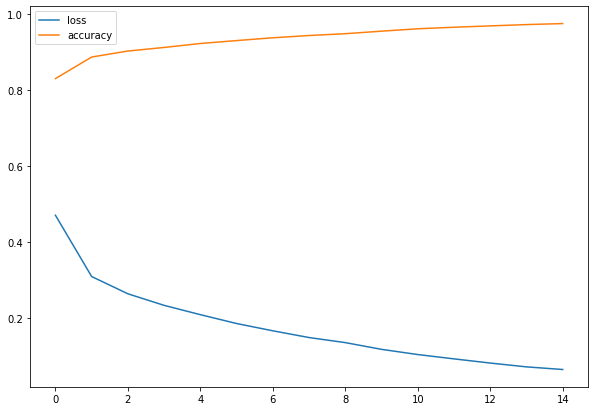

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10, 7))

In [ ]:
# Evaluar modelo
loss, test_acc = cnn.evaluate(testing_batches)

print(test_acc)

938/938 [==============================] - 2s 2ms/step - loss: 0.0469 - accuracy: 0.9835
0.9835166931152344


En este caso, podemos ver que nuestro *accuracy* final es mayor al que obtuvimos con la red neuronal regular. Sin embargo, es importante enfatizar que una CNN tendrá mayores capacidades para generalizar la tarea de detección, y de esta manera, rendir bien con nuevas instancias. 

## **2. Redes Neuronales Convolucionales (CNNs) para un Dataset Propio**

Como se mencionó al inicio, en la vida real, las imágenes están a colores y la posición de un objeto puede variar. Un modelo ideal reconocería ciertas características de un objeto sin importar el fondo, la iluminación, o el cambio de perspectiva. Es por eso la importancia de aprovechar modelos mas profundos como las CNNs. Esto nos permitirá llevar la tarea de clasificación al siguiente nivel. 

Hasta ahora, nos enfocamos en usar un dataset básico con imágenes de 28x28 pixeles. 

En consecuencia, esta vez exploraremos un nuevo camino para definir arquitecturas de CNNs basado en clases y herencia. Además, nos centraremos en usar un dataset externo (que podría ser propio y no parte de `tensorflow_datasets`) y entrenar el modelo usando un subconjunto de validación. 

### 2.1 Importar librerías. Descargar un dataset desde Kaggle. 

¿Recuerdas el dataset con escenarios y problemas urbanos que usamos desde Kaggle en el **Laboratorio 8: Introducción a Pandas**? Ahora lo utilizaremos para entrenar un clasificador de problemas urbanos en base imágenes. 

Para ayudarte a recordar, esta es la descripción hecha sobre el dataset en el Laboratorio 8: 

> El dataset con el que trabajaremos se denomina "City Problems Dataset". Este es un conjunto de datos relativamente nuevo con imágenes de problemas en entornos urbanos. 

> El dataset contiene 23,877 imágenes a todo color (2 Gb), de las cuales solo 15,223 imágenes tienen una etiqueta registrada. El resto esta orientado para la etapa de evaluación de un modelo de inteligencia artificial. 
Este conjunto de datos incluye 8 clases:
- **Clase 0:** no hay evento
- **Clase 1:** árbol caído
- **Clase 2:** fuego
- **Clase 3:** inundación
- **Clase 4:** mal camino
- **Clase 5:** atasco de tráfico
- **Clase 6:** basura
- **Clase 7:** accidente de tráfico

Los pasos siguientes serán similares a los explicados en el laboratorio 8 y tienen como objetivo descargar el dataset y ubicar los archivos, para que estos puedan ser procesados por el modelo CNN. 

In [ ]:
from sklearn.model_selection import train_test_split
import json
import os
from tqdm.auto import tqdm
import shutil
import random
import cv2

# Instalar la librería de Kaggle para descargar datasets
!pip install kaggle

# Antes de descargar el dataset, es importante definir las credenciales para acceder al API de Kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# Puedes crear tu propio token y username de la API de Kaggle en https://www.kaggle.com/
api_token = {"username":"edwinsalcedo","key":"AGREGAR TU API KEY AQUI"}

# Crear un archivo con las credenciales, de tal forma que kaggle pueda leerlas facilmente
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


Es hora de descargar el dataset el dataset y estructurar sus carpetas para mejorar su usabilidad.

In [ ]:
%cd /content

# Comprobar si el conjunto de datos ya se ha descargado
if not os.path.exists('./city_problems'):
  os.makedirs('city_problems')
else: 
  !rm -rf city_problems

# Descargar un dataset desde Kaggle
!kaggle datasets download -d tunhunhminh/demodata -p city_problems

# Descomprimir dataset 
!unzip -qn '/content/city_problems/demodata.zip' -d /content/city_problems > /dev/null
!rm /content/city_problems/demodata.zip

# Dado que el subconjunto test no contiene etiquetas, nos enfocaremos en abrir 
# las anotaciones provistas en train.csv. Este subconjunto sera luego dividido para
# obtener un subconjunto de entrenamiento (train), validación (val) y evaluación (test)
dataset = pd.read_csv('/content/city_problems/train.csv')

TRAINSET_PATH = "/content/train_data"
VALIDSET_PATH = "/content/valid_data"
TESTSET_PATH = "/content/test_data"

categories = ["no_event","fallen_tree","fire","flooding","bad_road","traffic_jam","garbage","traffic_accident"]

# Dividir el conjunto de datos en subconjuntos de entrenamiento, validación y prueba con Scikit-learn
train, test = train_test_split(dataset, test_size=0.15)
train, valid = train_test_split(train, test_size=0.17)

train["image_path"] = " "
test["image_path"] = " "
valid["image_path"] = " "

def sort_subset(subset, target_path):
  ''' Esta función distribuye las imágenes desde una carpeta hacia múltiples
      carpetas, esto en base a las categorías a las que pertenecen las imágenes. 
  '''
  # Comprobar si las nuevas carpetas para el dataset organizado ya fueron creadas
  if os.path.exists(target_path):
    !rm -rf "$target_path"

  !mkdir "$target_path"
  dirs = {}

  # Mover cada imagen a su carpeta respectiva
  for idx, category in enumerate(categories): 
    !mkdir "$target_path/$category"
    dirs[idx] = target_path+"/"+category

  for idx, sample in tqdm(subset.iterrows(), total=len(subset)):
    image_name = subset.at[idx,"image_id"]
    category = subset.at[idx,"label"]

    new_path = dirs[category]+"/"+image_name

    shutil.copy("/content/city_problems/train/train/"+image_name,new_path)  
    subset.at[idx,"image_path"] = new_path
  
  print("Done! ",target_path)
  return subset

train = sort_subset(train,TRAINSET_PATH)
valid = sort_subset(valid,VALIDSET_PATH)
test = sort_subset(test,TESTSET_PATH)

train = train.reset_index()
valid = valid.reset_index()
test = test.reset_index()

# Mostrar la nueva organización de carpetas en las carpetas train_data y test_data
print(os.listdir(TRAINSET_PATH))
print(os.listdir(VALIDSET_PATH))
print(os.listdir(TESTSET_PATH))

/content
100% 1.89G/1.89G [00:06<00:00, 327MB/s]
100% 1.89G/1.89G [00:06<00:00, 300MB/s]


  0%|          | 0/10739 [00:00<?, ?it/s]

Done!  /content/train_data


  0%|          | 0/2200 [00:00<?, ?it/s]

Done!  /content/valid_data


  0%|          | 0/2284 [00:00<?, ?it/s]

Done!  /content/test_data
['no_event', 'bad_road', 'fire', 'garbage', 'traffic_jam', 'traffic_accident', 'fallen_tree', 'flooding']
['no_event', 'bad_road', 'fire', 'garbage', 'traffic_jam', 'traffic_accident', 'fallen_tree', 'flooding']
['no_event', 'bad_road', 'fire', 'garbage', 'traffic_jam', 'traffic_accident', 'fallen_tree', 'flooding']


In [ ]:
print("Número de instancias para el subconjunto de entrenamiento:", len(train))
print("Número de instancias para el subconjunto de validación:", len(valid))
print("Número de instancias para el subconjunto de evaluación:", len(test))

Número de instancias para el subconjunto de entrenamiento: 10739
Número de instancias para el subconjunto de validación: 2200
Número de instancias para el subconjunto de evaluación: 2284


Visualizar un conjunto de instancias

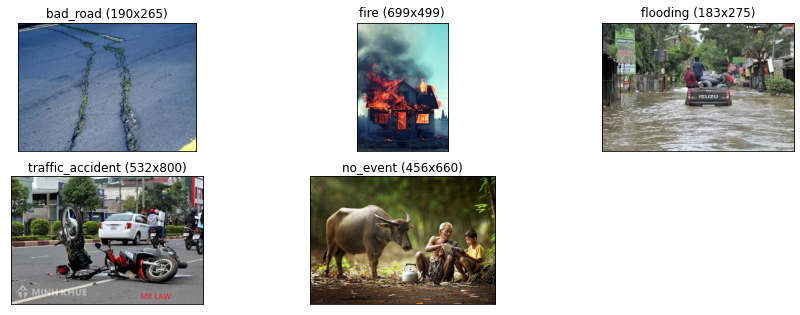

In [ ]:
def visualize(image_array):
  plt.rcParams["figure.figsize"] = (15,8) 

  for index, sample in enumerate(image_array):
    img = cv2.imread(sample[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, index+1), plt.imshow(img)
    plt.title(sample[1]+" ("+str(img.shape[0])+"x"+str(img.shape[1])+")")
    plt.xticks([]), plt.yticks([])

# Seleccionar aleatoriamente un conjunto de imágenes
random_category = random.randint(0,len(categories)-1)
images = []
num_images = 5

for num in range(num_images):
  random_image = random.randint(0,len(train)-1)
  images.append([train.at[random_image,"image_path"],categories[train.at[random_image,"label"]]])

visualize(images)

### 2.2 Preprocesamiento de datos

En el curso vimos varios métodos para mejorar nuestras imágenes y resaltar caracteristicas importantes. Este tipo de preprocesamiento debería ser aplicando antes de iniciar esta sección, por lo que nuestras imágenes estarían en buenas condiciones para aplicarles el preprocesamiento existente por parte de TF. 

El módulo `keras.preprocessing.image.ImageDataGenerator` de TF, también conocido como generador de datos, tiene capacidades para cargar, procesar, y transformar nuestras imágenes de entrada para su utilización con modelos. Los generadores son el camino mas habitual para cargar datos en TF. En este punto, configuremos generadores de datos que lean imágenes en nuestras carpetas de origen, las conviertan a tensores `float32` y las pasen a nuestra CNN con sus etiquetas respectivas. Tendremos un generador individual para las imágenes de entrenamiento, de validación y de evaluación.

Nuestros generadores producirán lotes (baches) de imágenes de tamaño 300x300 y sus etiquetas en formato binario. Como vimos en el anterior laboratorio, los datos que ingresen al modelo deben normalizarse para que la red pueda procesarlos de la mejor forma. En nuestro caso, procesaremos previamente nuestras imágenes normalizando los valores de píxeles para que estén en el rango [0, 1] (originalmente todos los valores están en el rango [0, 255]). 



Esto se puede hacer a través de la clase keras.preprocessing.image.ImageDataGenerator utilizando el parámetro rescale. Esta clase ImageDataGenerator le permite instanciar generadores de lotes de imágenes aumentadas (y sus etiquetas) a través de .flow (datos, etiquetas) o .flow_from_directory(directorio). Estos generadores se pueden usar con los métodos del modelo Keras que aceptan generadores de datos como entradas: fit_generator, Evaluation_generator y predict_generator.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Todas las imágenes seran divididas entre el maximo valor por canal, por lo que quedaran rescaladas entre el 0 y 1. 
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Tamaño del lote (imágenes a procesar por el modelo al mismo tiempo)
BATCH_SIZE = 32
VALIDSET_PATH = "/content/valid_data"
TESTSET_PATH = "/content/test_data"


# Importar datos desde los directorios y convertirlos en lotes de tensores
train_data = train_datagen.flow_from_directory(TRAINSET_PATH,
                                               batch_size=BATCH_SIZE, # tamaño del lote
                                               target_size=(224, 224), # convertir todas las imágenes a 224 x 224
                                               class_mode="categorical", # tipo de problema, usar 'binary' si tuviesemos dos clases
                                               seed=42) # semilla para generar las mismas selecciones durante los experimentos

valid_data = valid_datagen.flow_from_directory(VALIDSET_PATH,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

test_data = test_datagen.flow_from_directory(TESTSET_PATH,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)


Found 10739 images belonging to 8 classes.
Found 2200 images belonging to 8 classes.
Found 2284 images belonging to 8 classes.


### 2.3 Definir la CNN


In [ ]:
new_cnn = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(8, activation='softmax') # 8 nodos finales por las 8 categorías existentes en los datos
])

new_cnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_21 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_23 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

La columna "Output Shape" muestra cómo evoluciona el tamaño de los mapas de características (feature maps) en cada capa. Las capas de convolución reducen un poco el tamaño de los mapas de entidades debido a los filtros, y cada capa de pooling reduce a la mitad las dimensiones. Por otra parte, TF también tiene una herramienta para ver las capas de un modelo a través de un gráfico. 

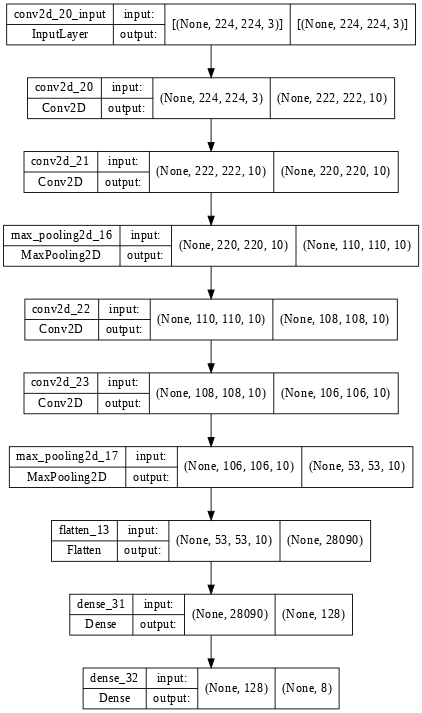

In [ ]:
tf.keras.utils.plot_model(new_cnn, show_shapes=True, dpi=64)

### 2.4 Entrenar la CNN

Cabe mencionar que esta sección siempre esta orientada a que usted realice multiples experimentos para encontrar los mejores hiperparametros, arquitecturas, optimizadores, etc, para un modelo y una tarea de aprendizaje automatico. 

In [ ]:
# Compilar el modelo definiendo algunos hiperparametros
new_cnn.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

EPOCHS = 15

# Entrenar el modelo
history = new_cnn.fit(train_data,  
                        epochs=15,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/15
336/336 [==============================] - 72s 213ms/step - loss: 1.4111 - accuracy: 0.4963 - val_loss: 1.1908 - val_accuracy: 0.5841
Epoch 2/15
336/336 [==============================] - 71s 211ms/step - loss: 0.9708 - accuracy: 0.6591 - val_loss: 1.0274 - val_accuracy: 0.6582
Epoch 3/15
336/336 [==============================] - 71s 211ms/step - loss: 0.6385 - accuracy: 0.7822 - val_loss: 1.0406 - val_accuracy: 0.6459
Epoch 4/15
336/336 [==============================] - 70s 209ms/step - loss: 0.3144 - accuracy: 0.8949 - val_loss: 1.1975 - val_accuracy: 0.6577
Epoch 5/15
336/336 [==============================] - 70s 209ms/step - loss: 0.1223 - accuracy: 0.9631 - val_loss: 1.8128 - val_accuracy: 0.6573
Epoch 6/15
336/336 [==============================] - 70s 209ms/step - loss: 0.0794 - accuracy: 0.9770 - val_loss: 1.7706 - val_accuracy: 0.6732
Epoch 7/15
336/336 [==============================] - 70s 209ms/step - loss: 0.0335 - accuracy: 0.9912 - val_loss: 2.1099 - val_ac

**¿Por qué crees que cada época requiere mas tiempo para completar 😴?**

Esto es principalmente porque ahora estamos lidiando con imágenes a color mas grandes que lo que teníamos en Fashion MNIST. Esto significa que estamos operando con tres canales (imágenes) en vez de solo uno por imagen como lo hacíamos antes. Aunque el presente dataset (aprox. 10,000 imágenes) no sea mas grande el Fashion MNIST (aprox. 70,000 imágenes), las imágenes son mas grandes, por ende cada época requiere mas tiempo. Entonces, el razonamiento intuitivo aquí es que cuantos más imágenes tenga o mas canales tengan o mas amplias sean, más tiempo tardará un modelo en encontrar patrones.

Ahora veamos como le fue al modelo en base sus métricas históricas por época. Esta vez definiremos una función para mostrar la visualización. 

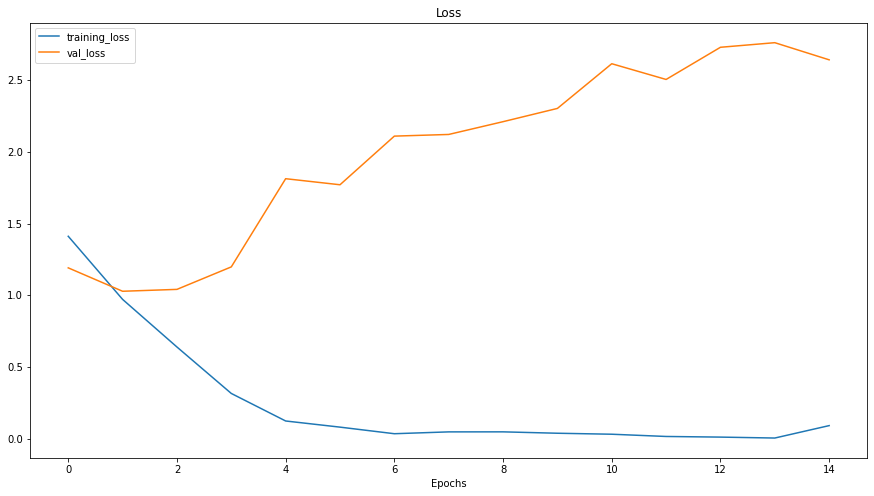

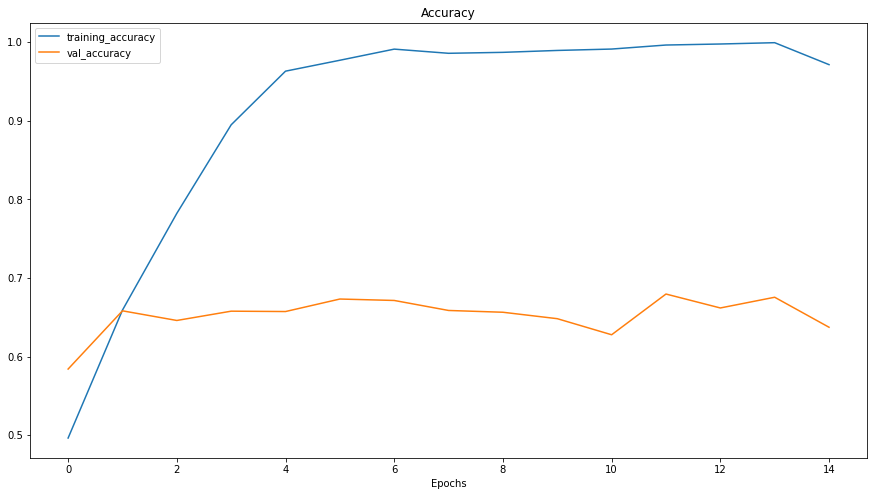

In [ ]:
def plot_loss_accuracy_curves(history):
  """
  Devuelve curvas de pérdida separadas para métricas de entrenamiento y validación
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Graficar perdida (Loss)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Graficar presición (accuracy)
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

plot_loss_accuracy_curves(history)

Al parecer existe una gran brecha entre las curvas de pérdida de entrenamiento y validación. Ya vimos este tipo de problemas en clase. Parece que nuestro modelo se está sobreajustando el conjunto de entrenamiento. En otras palabras, obtiene excelentes resultados para los datos de entrenamiento, pero no logra generalizar bien para nuevos datos y tiene un rendimiento deficiente en los datos de validación. 

Estos son algunos caminos para evitar sobreajuste: 

- **Obtener más datos:** Tener más datos le da al modelo más chances para aprender patrones que pueden  generalizar mas casos para generar inferencias para nuevas imágenes.
- **Simplificar el modelo:** Puede ser que el modelo sea demasiado complicado para los datos. Esto significa que está aprendiendo demasiado bien los patrones de las imágenes y no puede generalizar bien a los imágenes nuevas. Una forma de simplificar un modelo es reducir el número de capas o reducir el número de unidades ocultas en cada capa.
- **Aplicar aumentación de datos:** Incrementar datos sintéticamente tiene como fin generar nuevos datos de entrenamiento, de una manera que el dataset sea más difícil de aprender para el modelo. Si un modelo puede aprender patrones en datos aumentados, el modelo puede generalizar mejor a imágenes no vistas.
- **Utilizar Transferencia de Aprendizaje:** La transferencia de aprendizaje conlleva aprovechar los patrones (también llamados pesos preentrenados) de un modelo que haya sido entrenado previamente en una gran variedad de imágenes como ImageNet. Esta es una técnica que veremos en el siguiente laboratorio. 

Esta vez, nos enfocaremos en la tercera opción: **Aumentar los datos**. 

### 2.5 Aumentar los datos

In [ ]:
# Crear datos sintéticos
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # Nota: esta y las siguientes 4 líneas definen como se crearan nuevas instancias
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(TRAINSET_PATH,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 10739 images belonging to 8 classes.


Es importante mencionar que las nuevas imágenes seran creadas sintéticamente cuando el subconjunto `train_data_augmented` sea usado por el modelo, por lo que cada epóca tendra una duración mas larga. 

Ahora definimos nuevamente el modelo y lo entrenaremos con el nuevo subconjunto de entrenamiento. 

Epoch 1/15
336/336 [==============================] - 163s 482ms/step - loss: 1.8507 - accuracy: 0.2821 - val_loss: 1.5753 - val_accuracy: 0.4291
Epoch 2/15
336/336 [==============================] - 162s 482ms/step - loss: 1.5642 - accuracy: 0.4288 - val_loss: 1.2760 - val_accuracy: 0.5300
Epoch 3/15
336/336 [==============================] - 162s 483ms/step - loss: 1.3810 - accuracy: 0.5078 - val_loss: 1.1740 - val_accuracy: 0.5823
Epoch 4/15
336/336 [==============================] - 162s 482ms/step - loss: 1.2807 - accuracy: 0.5463 - val_loss: 1.1437 - val_accuracy: 0.5923
Epoch 5/15
336/336 [==============================] - 162s 481ms/step - loss: 1.2385 - accuracy: 0.5628 - val_loss: 1.0854 - val_accuracy: 0.6100
Epoch 6/15
336/336 [==============================] - 162s 481ms/step - loss: 1.2100 - accuracy: 0.5792 - val_loss: 1.2068 - val_accuracy: 0.5941
Epoch 7/15
336/336 [==============================] - 162s 481ms/step - loss: 1.1655 - accuracy: 0.5888 - val_loss: 1.0743 -

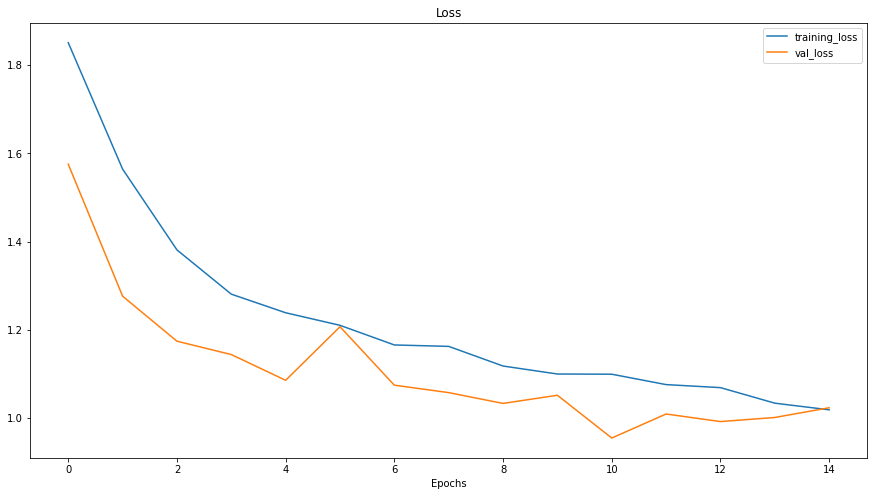

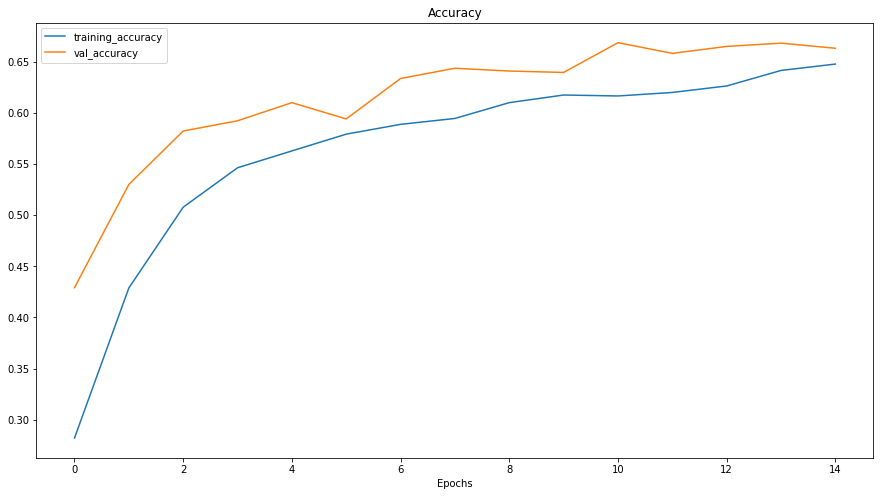

In [ ]:
new_cnn_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(8, activation='softmax') # 8 nodos finales por las 8 categorías existentes en los datos
])

new_cnn_2.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Entrenar el modelo
history = new_cnn_2.fit(train_data_augmented, 
                          epochs=15,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=valid_data,
                          validation_steps=len(valid_data))

plot_loss_accuracy_curves(history)

Podemos ver que el modelo lo esta haciendo mucho mejor. Incluso parece que si lo mantenemos entrenando durante más tiempo (más épocas), las métricas de validación podrían seguir mejorando. En realidad, este proceso es de prueba y error, así que lo que sigue en este punto es experimentar con las estrategias descritas en clases, por ejemplo  definir los hiperparametros, mejorar los datos, estructurar la arquitectura, todo esto con el fin de obtener el mejor modelo posible para la tarea y el conjunto de datos. Una vez lo hayamos conseguido, podremos pasar a la siguiente etapa.

### 2.6 Evaluar el modelo

In [ ]:
# Evaluar con el subconjunto de evaluación
new_cnn_2.evaluate(test_data)

72/72 [==============================] - 13s 177ms/step - loss: 0.9750 - accuracy: 0.6629


[0.9750249981880188, 0.6628721356391907]

## **Ejercicio 1:** Visualización de resultados

En este ejercicio deberas programar una función para visualizar resultados de predicción pasando instancias del subconjunto de validación. Puedes tomar como ejemplo el resultado de la siguiente celda. La función deberá permitir la definición de cuantas instancias se desea ver en la gráfica final. Cada instancia deberá tener como título en verde a la categoría predecida y a la categoría real si ambas coinciden, caso contrario, estas deberán aparecer en rojo. 

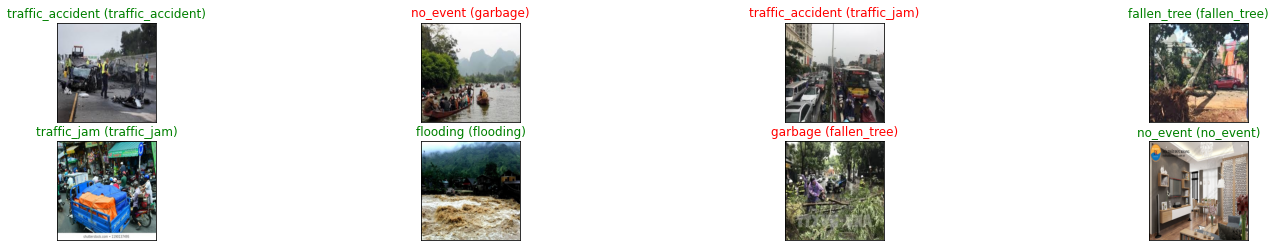

In [ ]:
## Completar

## **Ejercicio 2:** Métricas de Evaluación

Para este ejercicio, tendrás que calcular y visualizar las métricas con el subconjunto de evaluación para el último modelo. Para esto, deberas completar el entrenamiento con 15 epocas. Las métricas que se esperan aquí son: Precisión,  Logarithmic Loss, Confusion Matrix, AUC y F1 Score. Puedes usar `matplotlib` y/o `sklearn.metrics` para completar este ejercicio.

## **Ejercicio 3:** Inferencia

Este ejercicio requiere que descargues imagenes similares a las existentes en el dataset (escenarios urbanos con problemas) desde Google Images y las uses para clasificarlas con el último modelo entrenado. Puedes usar el script del siguiente [link](https://gist.github.com/EdwinTSalcedo/9550f91d2be47ad17bda3e540f62ad27) como ayuda, además de la función `.predict()` descrita en el Laboratorio 10. 

## **Ejercicio 4:** Trabaja con tu Propio Dataset

¿Recuerdas el dataset que seleccionaste para resolver el **Laboratorio 8: Introducción a Pandas**? En este ejercicio deberas aplicar una CNN para clasificar las imágenes de tu dataset seleccionado, tomando en cuenta las categorías presentes en dicho dataset. Su solución debera mostrar la metrica de `accuracy` y `F1 score` final del subconjunto de evaluación. 

## **Ejercicio 5:** Transferencia de Aprendizaje 

Finalmente, debera implementar transfer learning a uno de las tareas de aprendizaje resueltas en los últimos 4 ejercicios. TensorFlow cuenta con muchos recursos y tutoriales para aplicar transfer learning, sin embargo, se sugiere revisar los detalles de la implementación existentes en este [link](https://www.tensorflow.org/tutorials/images/transfer_learning). Cabe mencionar que el sitio web también esta disponible en el idioma español, seleccionando idioma en la parte superior. 



## Referencias

1. El modelo Sequential https://www.tensorflow.org/guide/keras/sequential_model
2. Transferencia de Aprendizaje https://www.tensorflow.org/tutorials/images/transfer_learning 
3. Redes Neuronales Convolucionales https://www.tensorflow.org/tutorials/images/cnn 